In [1]:
from trachoma.trachoma_functions import *
import multiprocessing
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns
num_cores = multiprocessing.cpu_count()

#############################################################################################################################
#############################################################################################################################

# initialize parameters, sim_params, and demography

params = {'N': 2500,
          'av_I_duration' : 2,
          'av_ID_duration':300/7,
          'inf_red':0.45,
          'min_ID':11, #Parameters relating to duration of infection period, including ID period
          'av_D_duration':200/7,
          'min_D':1, #Parameters relating to duration of disease period
          'dis_red':0.3,
          'v_1':1,
          'v_2':2.6,
          'phi':1.4,
          'epsilon':0.2,#Parameters relating to lambda function- calculating force of infection
          #Parameters relating to MDA
          'MDA_Cov':0.8,
          'MDA_Eff': 0.85, # Efficacy of treatment
          'rho':0,
          'nweeks_year':52,
          'babiesMaxAge':0.5, #Note this is years, need to check it converts to weeks later
          'youngChildMaxAge':9,#Note this is years, need to check it converts to weeks later
          'olderChildMaxAge':15, #Note this is years, need to check it converts to weeks later
          'b1':1,#this relates to bacterial load function
          'ep2':0.114,
          'n_inf_sev':38,
          'TestSensitivity': 0.96,
          'TestSpecificity': 0.965,
          'SecularTrendIndicator': 1,
          'SecularTrendYearlyBetaDecrease': 0.01,
          'vacc_prob_block_transmission':  0, 
          'vacc_reduce_bacterial_load': 0, 
          'vacc_reduce_duration': 0,
          'vacc_coverage': 0,  
          'vacc_waning_length': 52 * 5,
          'mda_waning_length': 52 * 10,
          'mda_prob_block_transmission':1, 
          'mda_reduce_bacterial_load': 1, 
          'importation_rate': 1/(52*2500),
          'importation_reduction_rate': (0.9)**(1/10),
          'surveyCoverage' : 0.4,
          'importation_reduction_length': 25,
          'infection_risk_shape': 1,
          'min_importation_rate' : 1/(52*2500 * 15)
          }


burnin = 80*52
timesim = burnin + 40*52

sim_params = {'timesim': timesim, 
              'burnin': burnin,
              'N_MDA':5,
              'n_sim':200}


demog = {'tau': 0.0004807692, 
         'max_age': 3120,
         'mean_age': 1040}



previous_rounds = 0


Start_date = date(1996,1, 1)
End_date = date(2030,12,31)


def create_initial_population(initial_prevalence: float, MDAData, parameters, distToUse = "Poisson"):
    vals = Set_inits(parameters, demog, sim_params, MDAData, np.random.get_state(), distToUse=distToUse)
    ids = np.random.choice(
        range(parameters["N"]), int(initial_prevalence * parameters["N"]), replace=False
    )
    vals["IndI"][ids] = 1
    vals["T_latent"][ids] = vals["Ind_latent"][ids]
    vals["No_Inf"][ids] = 1
    return vals



In [2]:


# what proportion of the population should begin infected
initial_infect_frac = 0.1

# specify that we want yearly output from the model
outputYear = range(1996, 2021)
outputTimes = getOutputTimes(outputYear)
outputTimes = get_Intervention_times(outputTimes, Start_date, sim_params['burnin'])
MDAData = VaccData = [[3018.0, 0, 100.0, 0.1, 0, 2],
                        [3019.0, 0, 0.5, 0.8, 1, 2]]
        
MDA_times = vacc_times = np.array([52000, 52520, 53040])
distToUse = "Exponential"
burnin = sim_params['burnin']
timesim = burnin


In [3]:
# seed the randomness of the simulation
seed = 10
np.random.seed(seed)
random_state = np.random.get_state()

# create population
vals = create_initial_population(initial_infect_frac, MDAData, params, distToUse)


# choose shape of gamma distribution and the beta value
params['infection_risk_shape'] = 12 
beta = 0.14 

# run one simulation
out, _ = sim_Ind_MDA_Include_Survey(params, vals, timesim, burnin, demog, beta, MDA_times, MDAData,
                               vacc_times, VaccData,  outputTimes,
                                    doSurvey = False, doIHMEOutput= False, numpy_state = random_state, distToUse = distToUse)

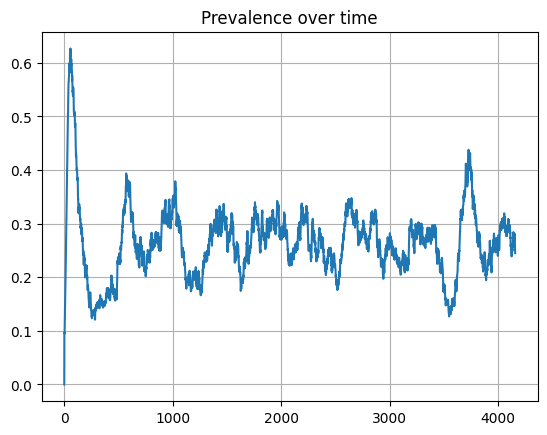

In [4]:
# plot disease prevalence
plt.plot(out['True_Prev_Disease_children_1_9'])
plt.title('Prevalence over time')
plt.grid(True)

In [5]:
IndD = np.zeros(len(out['IndD'])) # assume no one is diseased, as this decreases the force of infection

# calculate force of infection for each person over 1 week
lambda_base = getlambdaStep(params=params, Age=out['Age'], bact_load=out['bact_load'],
    IndD=IndD, Infection_risk= out['Infection_risk'], vaccinated=out['vaccinated'],time_since_vaccinated=out['time_since_vaccinated'],
    bet=beta, demog=demog)

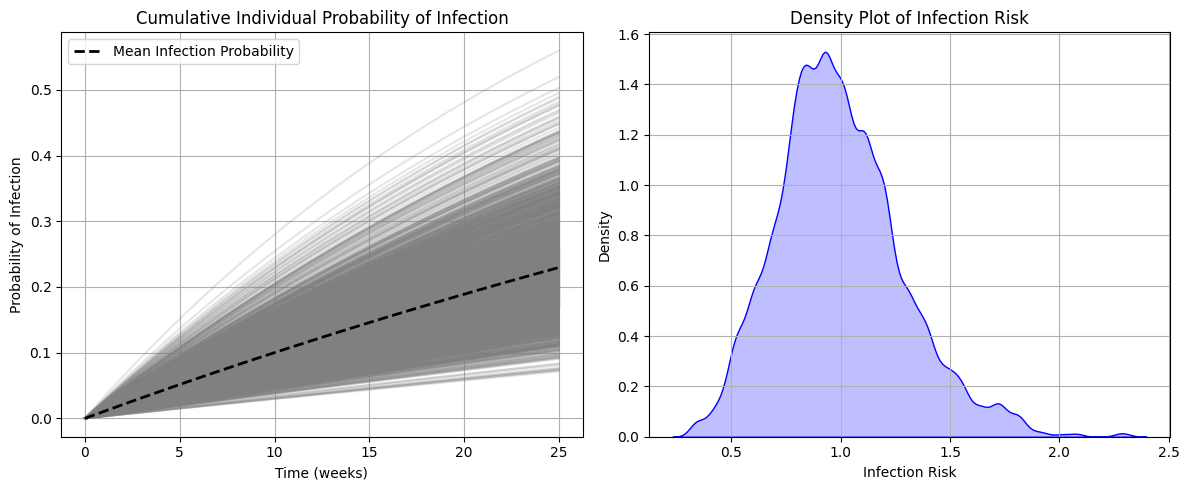

In [6]:
# Time and infection risk parameters
t_values = np.linspace(0, 25, 100)  # Time values from 0 to 25
num_individuals = len(lambda_base)  # Number of individuals to track

# Compute infection probabilities for each individual over time
P_infection_all = np.array([
    1 - np.exp(-lambda_base[i] * t_values) for i in range(num_individuals)
])

# Create figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

### Left plot: Infection probability curves ###
for i in range(num_individuals):
    axes[0].plot(t_values, P_infection_all[i], color='grey', alpha=0.2)

# Plot mean infection probability in black dashed line
mean_P_infection = np.mean(P_infection_all, axis=0)
axes[0].plot(t_values, mean_P_infection, "k--", linewidth=2, label="Mean Infection Probability")

axes[0].set_xlabel("Time (weeks)")
axes[0].set_ylabel("Probability of Infection")
axes[0].set_title("Cumulative Individual Probability of Infection")
axes[0].grid(True)
axes[0].legend()

### Right plot: Density plot of Infection Risk ###
sns.kdeplot(out['Infection_risk'], bw_adjust=0.5, ax=axes[1], fill=True, color="blue")

# Formatting for right plot
axes[1].set_xlabel("Infection Risk")
axes[1].set_ylabel("Density")
axes[1].set_title("Density Plot of Infection Risk")
axes[1].grid(True)

# Adjust layout and show plots
plt.tight_layout()
plt.show()
